In [3]:
import networkx as nx
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

plt.style.use("default")

In [5]:
# Simulates a discrete time infections over T_FIN weeks, on a graph with adjacency matrix W
# Returns the number of people for each state over the weeks, as well as the number of new infections and vaccinations (for each week)
# vaccinated_perc is an array containing the percentage of population vaccinated at each week (must have T_FIN elements), can be None to indicate no vaccination

def simulate_infection(W, T_FIN, initial_infections, beta, rho, vaccinated_perc):
    # Vectors to keep track of the evolution of the pandemic
    new_infections = np.zeros(T_FIN, dtype=int)
    S = np.zeros(T_FIN, dtype=int)
    I = np.zeros(T_FIN, dtype=int)
    R = np.zeros(T_FIN, dtype=int)
    new_vaccinations = np.zeros(T_FIN, dtype=int)

    if vaccinated_perc != None and len(vaccinated_perc) != T_FIN:
        print("Error: vaccination mumst contain T_FIN elements!")
        return

    # Initialize the state vector (S=0, I=1, R=2, vaccinated=3)
    n_agents = np.size(W, axis=1)
    x = np.zeros(n_agents)
    for i in range(initial_infections):
        j = np.random.randint(n_agents)
        x[j] = 1

    # Simulate T_FIN weeks
    for week in range(T_FIN):
        
        # Vaccination puts people in a new state (4), but since the amount of recovered patients shouldn't decrease
        # the count must be incremented each time a patient recovers (can't simply count the number of people in state R at the end of the week)
        if week != 0:
            R[week] = R[week - 1]
        
        # Vaccinate to meet vaccinated_perc
        if vaccinated_perc != None:
            unvaxxed = np.where(x != 3)[0]
            target = n_agents*vaccinated_perc[week]/100
            vaxxed = len(np.where(x == 3)[0])
            to_be_vaxxed = target - vaxxed
            
            if to_be_vaxxed > 0:
                vax = np.random.choice(unvaxxed, int(to_be_vaxxed), replace=False)
                x[vax] = 3
                new_vaccinations[week] = to_be_vaxxed
        
        for agent in range(n_agents):
            # Check if I mutates in R
            if x[agent] == 1:
                x[agent] = np.random.choice([2, 1], p=[rho, 1-rho])
                if x[agent] == 2:
                    R[week] += 1

            # Check if contagion happens
            elif x[agent] == 0:
                # Compute contagion probability
                neighbors = np.where(W[:,agent] == 1)[0]
                m = len(np.where(x[neighbors] == 1)[0])
                p_contagion = 1-(1-beta)**m

                # Check if infection happens
                x[agent] = np.random.choice([1, 0], p=[p_contagion, 1-p_contagion])
                if x[agent] == 1:
                    new_infections[week] += 1

        S[week] += len(np.where(x==0)[0])
        I[week] += len(np.where(x==1)[0])
            
    return S, I, R, new_infections, new_vaccinations



In [148]:
# Random graph generation

# Returns a graph with n_nodes nodes, with average degree k, generated using the preferential attachment model
def generate_random_graph(n_nodes, k):
    G = nx.complete_graph(k+1, create_using=nx.Graph)
    c = int(k/2)
    
    # Check if k is odd to see whether to alternate between c and c+1
    if k%2 != 0:
        odd = True
        increment = 1
    else:
        odd = False
        increment = 0
                
    # Compute degree of each node
    w = np.sum(nx.to_numpy_array(G), axis=1)
    node = len(w)
    while(node < n_nodes):
        # Compute probability of connecting to each node and choose neighbors
        prob = w/np.sum(w)
        neighbors = np.random.choice(range(node), c+increment, p=prob, replace=False)
        for n in neighbors:
            G.add_edge(node, n)
            
        w = np.sum(nx.to_numpy_array(G), axis=1)
        node = len(w)
        if odd:
            increment = 1-increment        
                
    return G

In [65]:
# Exercise 1.1.1

k = 6
n_agents = 500

# Generate symmetric k-regular graph's edges
edges = []
node_list = range(0, n_agents)

for i in node_list:
    a = int(i-k/2)
    
    for j in range(k+1):
        ind = a+j
        if ind >= n_agents:
            ind -= n_agents
        node = node_list[ind]
        if(i != node):
            edges.append((i, node))

G = nx.Graph()
G.add_edges_from(edges)
W = nx.to_numpy_array(G)
edges = np.array(G.edges)

In [66]:
# Simulate Pandemic
N = 100
T_FIN = 15
initial_infections = 10
beta = 0.25
rho = 0.6

avg_S = np.zeros(T_FIN)
avg_I = np.zeros(T_FIN)
avg_R = np.zeros(T_FIN)
avg_new_infections = np.zeros(T_FIN)
for i in range(N):
    S, I, R, new_inf, _ = simulate_infection(W, T_FIN, initial_infections, beta, rho, None)
    avg_S += S
    avg_I += I
    avg_R += R
    avg_new_infections += new_inf
    
avg_S = avg_S/N
avg_I = avg_I/N
avg_R = avg_R/N
avg_new_infections = avg_new_infections/N

<BarContainer object of 15 artists>

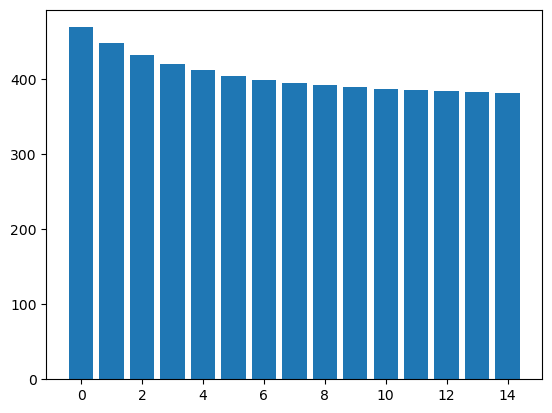

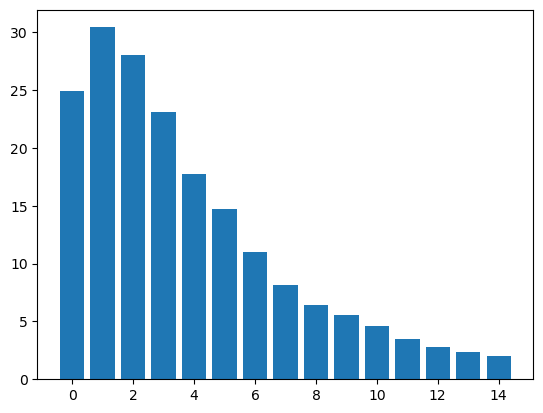

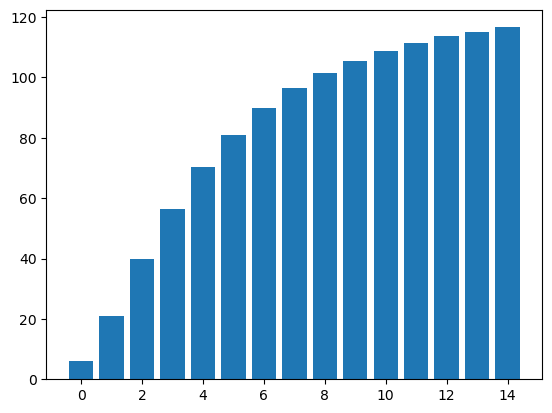

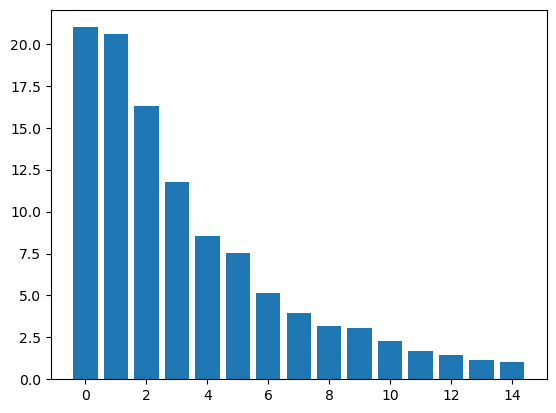

In [67]:
# Plots

f = plt.figure()
plt.bar(range(T_FIN), avg_S)
f = plt.figure()
plt.bar(range(T_FIN), avg_I)
f = plt.figure()
plt.bar(range(T_FIN), avg_R)
f = plt.figure()
plt.bar(range(T_FIN), avg_new_infections)

In [103]:
# Exercise 1.2

G = generate_random_graph(500, 6)
W = nx.to_numpy_array(G)

In [135]:
# Define infection and simulation parameters
N = 100
T_FIN = 15
initial_infections = 10
beta = 0.25
rho = 0.6
vaccines = None

# Initialize data vectors
avg_S = np.zeros(T_FIN)
avg_I = np.zeros(T_FIN)
avg_R = np.zeros(T_FIN)
avg_new_infections = np.zeros(T_FIN)

# Simulate N times and average
for i in range(N):
    S, I, R, new_inf, _ = simulate_infection(W, T_FIN, initial_infections, beta, rho, vaccines)
    avg_S += S
    avg_I += I
    avg_R += R
    avg_new_infections += new_inf
    
avg_S = avg_S/N
avg_I = avg_I/N
avg_R = avg_R/N
avg_new_infections = avg_new_infections/N

<BarContainer object of 15 artists>

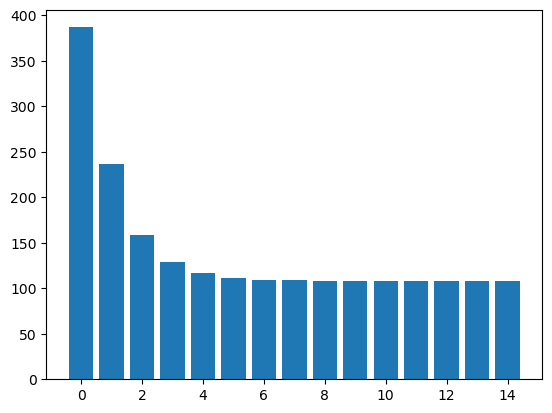

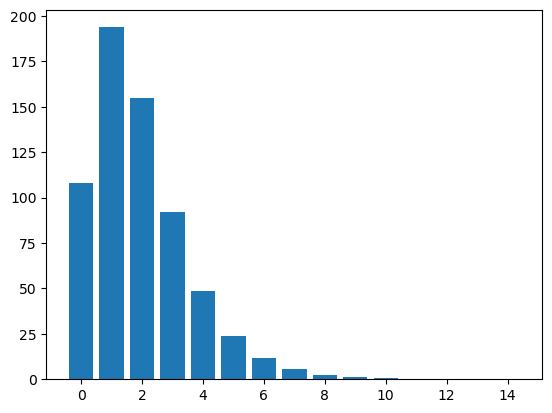

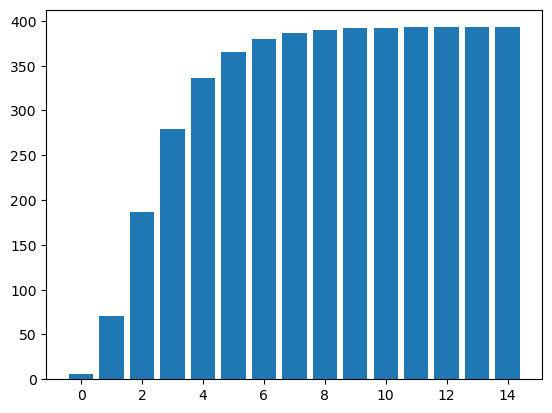

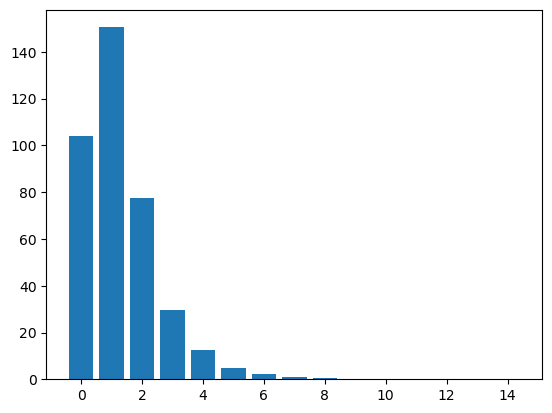

In [70]:
# Plots

f = plt.figure()
plt.bar(range(T_FIN), avg_S)
f = plt.figure()
plt.bar(range(T_FIN), avg_I)
f = plt.figure()
plt.bar(range(T_FIN), avg_R)
f = plt.figure()
plt.bar(range(T_FIN), avg_new_infections)

In [71]:
# Exercise 1.3

# Define infection and simulation parameters
N = 100
T_FIN = 15
initial_infections = 10
beta = 0.25
rho = 0.6
vaccines = [0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60]

# Initialize data vectors
avg_S = np.zeros(T_FIN)
avg_I = np.zeros(T_FIN)
avg_R = np.zeros(T_FIN)
avg_V = np.zeros(T_FIN)
avg_new_infections = np.zeros(T_FIN)
avg_new_vax = np.zeros(T_FIN)

# Simulate N times and average
for i in range(N):
    S, I, R, new_inf, new_vax = simulate_infection(W, T_FIN, initial_infections, beta, rho, vaccines)
    avg_S += S
    avg_I += I
    avg_R += R
    avg_new_infections += new_inf
    avg_new_vax += new_vax
    
avg_V += avg_new_vax
for w in range(1, T_FIN):
    avg_V[w] += avg_V[w-1]
avg_V = avg_V/N
avg_S = avg_S/N
avg_I = avg_I/N
avg_R = avg_R/N
avg_new_infections = avg_new_infections/N
avg_new_vax = avg_new_vax/N


<BarContainer object of 15 artists>

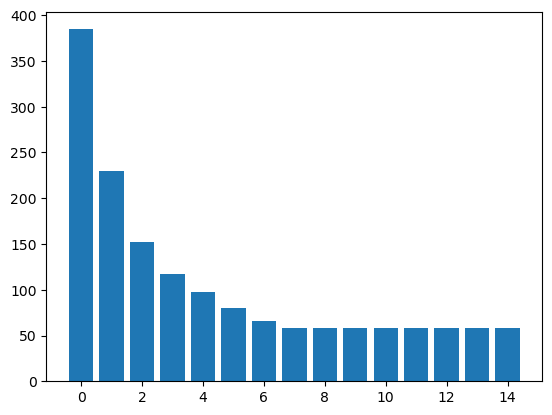

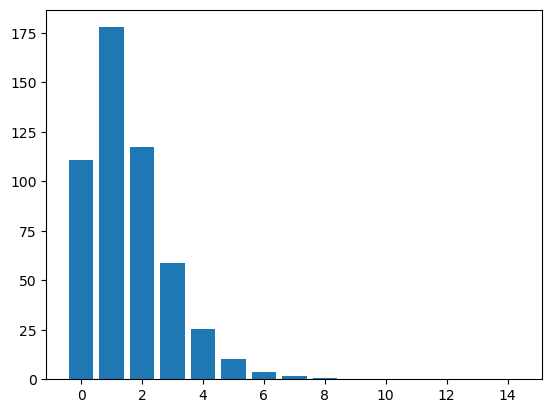

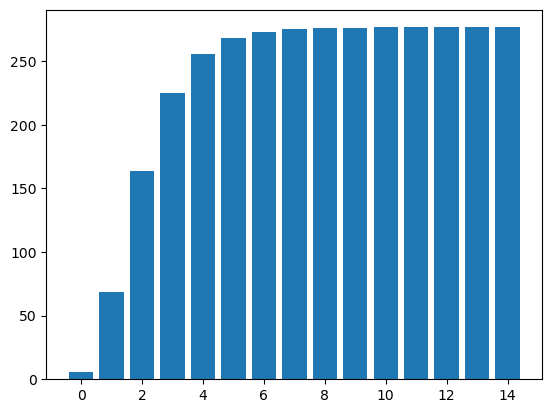

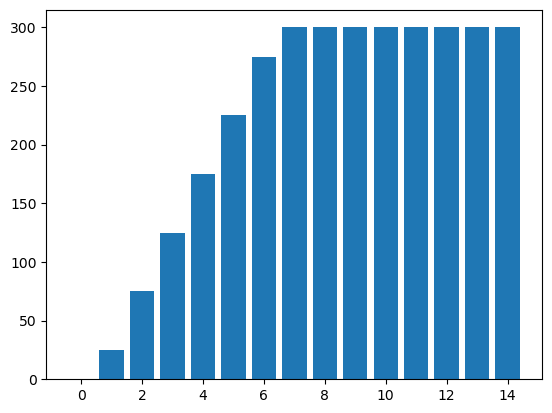

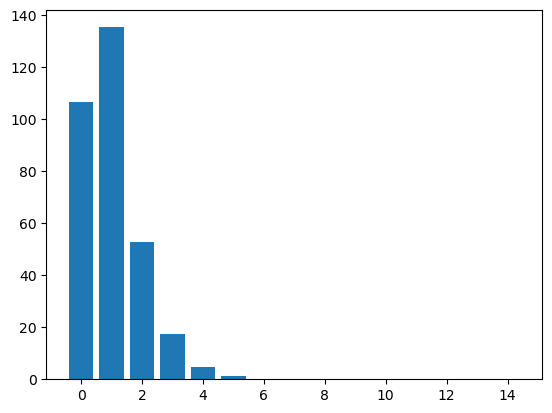

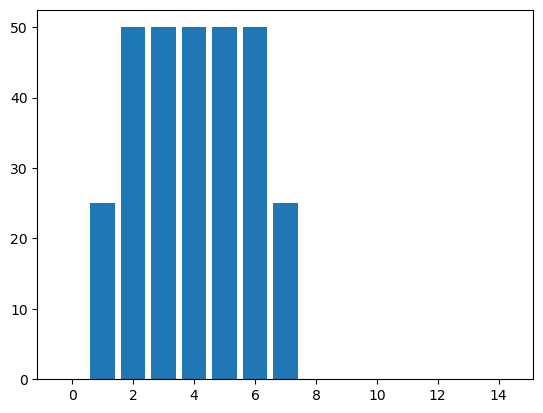

In [72]:
# Plots
 
f = plt.figure()
plt.bar(range(T_FIN), avg_S)
f = plt.figure()
plt.bar(range(T_FIN), avg_I)
f = plt.figure()
plt.bar(range(T_FIN), avg_R)
f = plt.figure()
plt.bar(range(T_FIN), avg_V)

f = plt.figure()
plt.bar(range(T_FIN), avg_new_infections)
f = plt.figure()
plt.bar(range(T_FIN), avg_new_vax)

In [159]:
# Exercise 1.4

vaccines = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60]
ground_truth = np.array([1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0])
initial_infections = 1
n_agents = 934
T_FIN = 15
N = 100

# Initial values for gradient descent
beta = 0.3
rho = 0.6
k = 10
# Threshold value of the RMSE to stop the descent
threshold = 1

# Increments for each variable
dk = 1
dr = 0.05
db = 0.05
done = False
    
# compute inital RMSE
G = generate_random_graph(n_agents, k)
W = nx.to_numpy_array(G)
avg_I = np.zeros(T_FIN)
for n_sim in range(N):
    _, I, _, _, _ = simulate_infection(W, T_FIN, initial_infections, beta, rho, vaccines)
    avg_I += I
avg_I = avg_I/N
last_RMSE = np.sqrt(1/T_FIN * np.sum(ground_truth - avg_I)**2)
print("Initial RMSE:", last_RMSE)

while not done:
    k_set = [k, k+dk, k-dk]
    rho_set = [rho, rho+dr, rho-dr]
    beta_set = [beta, beta-dr, beta+dr]
    # Generate all possible combinations of parameters (considering the increments)
    possible_params = np.array(np.meshgrid(k_set, rho_set, beta_set)).T.reshape(-1,3)
    best_RMSE = np.Inf
    best_params = []
    
    # Try all possible combinations of parameters
    for pp in possible_params:
        k_i = pp[0]
        rho_i = pp[1]
        beta_i = pp[2]
        
        G = generate_random_graph(n_agents, int(k_i))
        avg_I = np.zeros(T_FIN)
        for n_sim in range(N):
            _, I, _, _, _ = simulate_infection(W, T_FIN, initial_infections, beta_i, rho_i, vaccines)
            avg_I += I
        avg_I = avg_I/N
        
        RMSE_new = np.sqrt(1/T_FIN * np.sum(ground_truth - avg_I)**2)
        
        if(RMSE_new < best_RMSE):
            best_RMSE = RMSE_new
            best_params = [k_i, rho_i, beta_i]
        
    print("RMSE:", best_RMSE, "params", best_params)
    if best_params == [k, rho, beta]:
        done = True
    else:
        k, rho, beta = best_params
        last = best_RMSE

Initial RMSE: 199.45347835188701


KeyboardInterrupt: 